# Cluster and HII-regions Multi <a class="tocSkip">

the aim of this notebook is to combine the HII-region and cluster catalogues.
   
This notebook useses multiple galaxies at once.

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

from pnlf.packages import *

from pnlf.constants import tab10, single_column, two_column
from pnlf.plot import quick_plot

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
logging.basicConfig(stream=sys.stdout,
                    #format='(levelname)s %(name)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

logger = logging.getLogger(__name__)


# first we need to specify the path to the raw data
basedir = Path('..')
data_ext = Path('a:') #basedir / 'data' / 'raw' 

sample_table = ascii.read(basedir/'..'/'pnlf'/'data'/'interim'/'sample.txt')
sample_table.add_index('Name')
sample_table['SkyCoord'] = SkyCoord(sample_table['R.A.'],sample_table['Dec.'])
sample_table['power_index'] = 2.3
sample_table['power_index'][sample_table['AO'].mask]=2.8

## Read in data

### MUSE Nebulae Catalogue

In [3]:
with fits.open(basedir / 'data' / 'interim' / 'Nebulae_Catalogue_with_FUV_DR2.fits') as hdul:
    nebulae = Table(hdul[1].data)
    
with np.errstate(divide='ignore'):
    nebulae['[SIII]/[SII]'] = np.nan
    SII = nebulae['SII6716_FLUX_CORR']+nebulae['SII6730_FLUX_CORR']
    SIII = nebulae['SIII6312_FLUX_CORR']+nebulae['SIII9068_FLUX_CORR']
    nebulae[SII>0]['[SIII]/[SII]'] = SIII[SII>0]/SII[SII>0]
    nebulae['HA/FUV'] = nebulae['HA6562_FLUX_CORR']/nebulae['FUV_FLUX_CORR']

C:\Users\fabian\miniconda3\envs\pymuse\lib\site-packages\astropy\table\column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


In [4]:
from pnlf.auxiliary import filter_table
from pnlf.io import ReadLineMaps


# nebulae catalogue from Francesco (mostly HII-regions)
with fits.open(basedir / 'data' / 'interim' / 'Nebulae_Catalogue_with_FUV_DR2.fits') as hdul:
    nebulae = Table(hdul[1].data)
print(f'{len(nebulae)} nebulae in initial catalogue')

with np.errstate(divide='ignore'):
    nebulae['[SIII]/[SII]'] = np.nan
    SII = nebulae['SII6716_FLUX_CORR']+nebulae['SII6730_FLUX_CORR']
    SIII = nebulae['SIII6312_FLUX_CORR']+nebulae['SIII9068_FLUX_CORR']
    nebulae['[SIII]/[SII]'][SII>0] = SIII[SII>0]/SII[SII>0]
    nebulae['HA/FUV'] = nebulae['HA6562_FLUX_CORR']/nebulae['FUV_FLUX_CORR']
    
nebulae.rename_columns(['cen_x','cen_y'],['x','y'])

# we remove some objects that are not HII-regions
nebulae = filter_table(nebulae,BPT_NII=0,BPT_SII=0,BPT_OI=0)

#nebulae = nebulae[['region_ID','x','y','met_scal','Delta_met','logq_D91']]
nebulae['SkyCoord'] = SkyCoord(nebulae['cen_ra']*u.deg,nebulae['cen_dec']*u.deg,frame='icrs')

25678 nebulae in initial catalogue


### HST Cluster Catalogue

In [5]:
# create a new table
if 'clusters' in locals(): del clusters
    
for file in [x for x in  (data_ext / 'HST' / 'cluster catalogue').iterdir() if x.stem[:7].upper() in sample_table['Name']]: 
    name = file.stem[:7].upper()
    
    # cluster catalogues
    with fits.open(file) as hdul:
        tbl = Table(hdul[1].data)
    tbl['gal_name'] = name
    print(f'{len(tbl)} entries for {name}')    
 
    if 'clusters' in locals():
        clusters = vstack([clusters,tbl])
    else:
        clusters = tbl

print(f'initial catalogue has {len(clusters)} entries)')     
# only CLASS 1,2 and 3 are classified as clusters
clusters = clusters[np.isin(clusters['PHANGS_CLUSTER_CLASS'],[1,2,3])]
# remove LEGUS columns
clusters = clusters[[x for x in clusters.columns if 'LEGUS' not in x]]
# remove the PHANGS label from the column names
clusters.rename_columns([x for x in clusters.columns],[x.replace('PHANGS_','') for x in clusters.columns])
# add SkyCoord to match with MUSE data
clusters['SkyCoord'] = SkyCoord(clusters['RA']*u.degree,clusters['DEC']*u.degree)
print(f'final catalogue has {len(clusters)} entries')  

10498 entries for NGC0628
2155 entries for NGC1433
8679 entries for NGC1566
4310 entries for NGC3351
10153 entries for NGC3627
2167 entries for NGC4535
initial catalogue has 37962 entries)
final catalogue has 3755 entries


## Search for correlations

In [6]:
hst_sample      = set(np.unique(clusters['gal_name'])) 
astrosat_sample =set([x.stem.split('_')[0] for x in (data_ext/'Astrosat').iterdir() if x.is_file() and x.suffix=='.fits'])
nebulae_sample  = set(np.unique(nebulae['gal_name']))
muse_sample     = set(sample_table['Name'])

### FUV vs ionization

IC5332: rho=0.46, 332 objects
NGC0628: rho=0.45, 1308 objects
NGC1300: rho=0.32, 779 objects
NGC1365: rho=0.45, 965 objects
NGC1433: rho=0.35, 690 objects
NGC1512: rho=0.41, 382 objects
NGC1566: rho=0.33, 1017 objects
NGC2835: rho=0.66, 679 objects
NGC3627: rho=0.47, 1000 objects
NGC7496: rho=0.53, 341 objects


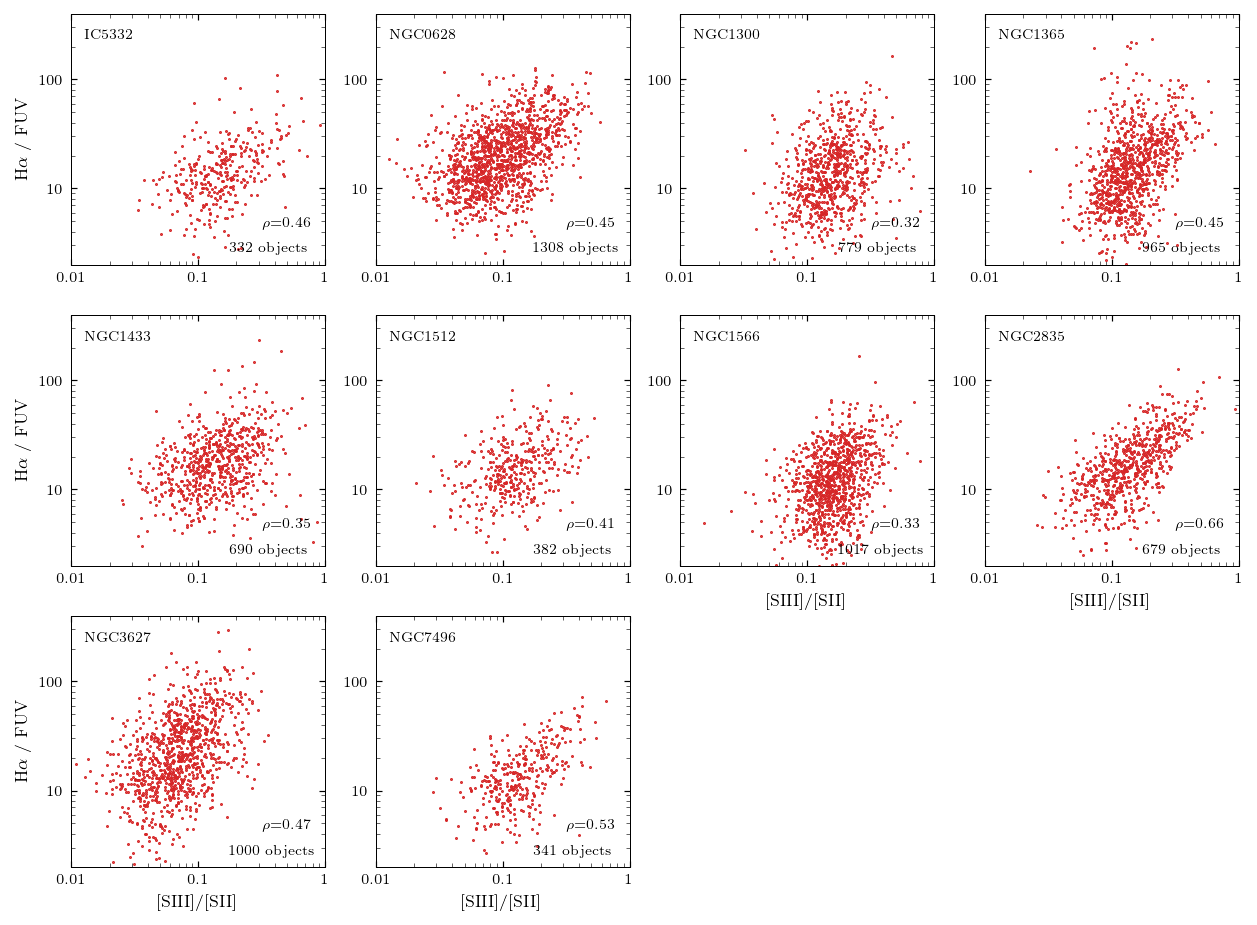

In [14]:
from scipy.stats import binned_statistic, pearsonr, spearmanr

sample = astrosat_sample & nebulae_sample
filename = basedir/'reports'/'all_objects_FUV_over_SII'

#----------------------------------------------
# DO NOT MODIFY BELOW
#----------------------------------------------
ncols = 4
nrows = int(np.ceil(len(sample)/ncols))

if nrows*ncols<len(sample):
    raise ValueError('not enough subplots for selected objects') 
width = 1.5*two_column
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes_iter = iter(axes.flatten())
    
vmin,vmax = np.min(catalogue['HA6562_FLUX']),np.max(catalogue['HA6562_FLUX'])
# loop over the galaxies we want to plot
for name in sorted(sample):  
    
    catalogue = nebulae[(nebulae['gal_name']==name)]
        
    # get the next axis and find position on the grid
    ax = next(axes_iter)
    if nrows>1 and ncols>1:
        i, j = np.where(axes == ax)
        i,j=i[0],j[0]
    elif ncols>1:
        i,j = 0, np.where(axes==ax)[0]
    elif nrows>1:
        i,j = np.where(axes==ax)[0],0
    else:
        i,j=0,0

    #catalogue = catalogue[catalogue['HA6562_FLUX']>np.nanpercentile(catalogue['HA6562_FLUX'],50)]
    catalogue = catalogue[catalogue['FUV_FLUX_CORR']>3*catalogue['FUV_FLUX_CORR_ERR']]
    catalogue = catalogue[catalogue['SII6716_FLUX_CORR']>3*catalogue['SII6716_FLUX_CORR_ERR']]
    catalogue = catalogue[catalogue['SIII9068_FLUX_CORR']>3*catalogue['SIII9068_FLUX_CORR_ERR']]

    r,p = spearmanr(catalogue['[SIII]/[SII]'],catalogue['HA/FUV'])
    print(f'{name}: rho={r:.2f}, {len(catalogue)} objects')

    im = ax.scatter(catalogue['[SIII]/[SII]'],catalogue['HA/FUV'],
               color='tab:red',
                #c=np.log(catalogue['HA6562_FLUX']),vmin=np.log(vmin),vmax=np.log(vmax),
               s=1,marker='.')
    
    ax.text(0.05,0.9,f'{name}', transform=ax.transAxes,fontsize=7)
    ax.text(0.75,0.15,r'$\rho$'+f'={r:.2f}',transform=ax.transAxes,fontsize=7)
    ax.text(0.62,0.05,f'{len(catalogue):.0f} objects', transform=ax.transAxes,fontsize=7)
    
    ax.set(xscale='log',yscale='log',xlim=[1e-2,1],ylim=[2,4e2])
    # https://stackoverflow.com/questions/21920233/matplotlib-log-scale-tick-label-number-formatting/33213196
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

    if i==nrows-1:
        ax.set_xlabel('[SIII]/[SII]')
    if j==0:
        ax.set_ylabel(r'H$\alpha$ / FUV')

        
for i in range(nrows*ncols-len(sample)):

    # remove the empty axes at the bottom
    ax = next(axes_iter)
    
    if i==0:
        ax.remove()
        #ax.axis('off')
        #fig.colorbar(im, ax=ax,label=r'$\log \mathrm{H}\alpha$',orientation='horizontal')
    else:
        ax.remove()

    # add the xlabel to the axes above
    axes[nrows-2,ncols-1-i].set_xlabel('[SIII]/[SII]')
        
plt.savefig(filename.with_suffix('.png'),dpi=600)
plt.savefig(filename.with_suffix('.pdf'),dpi=600)

plt.show()


### Compare with HST ages

NGC0628: 260 objects in joined catalogue
NGC1433: 159 objects in joined catalogue
NGC1566: 326 objects in joined catalogue
NGC3627: 279 objects in joined catalogue


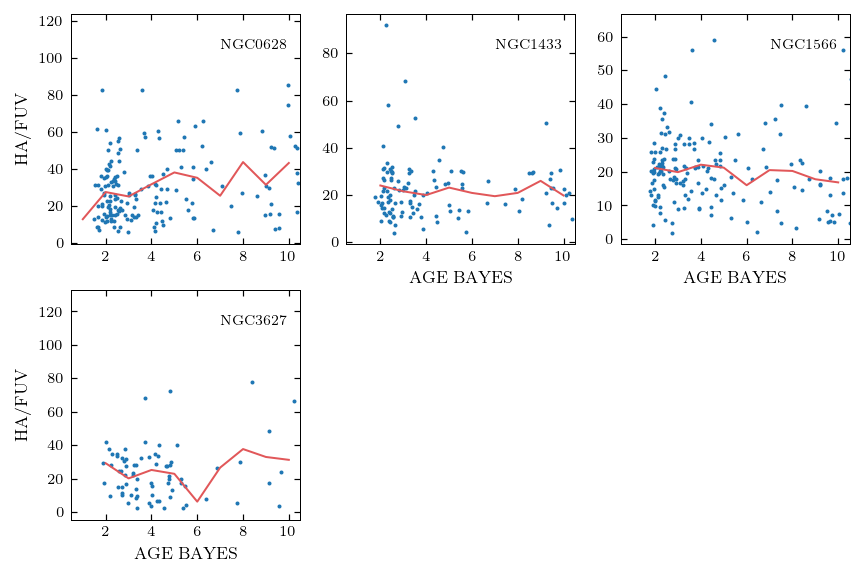

In [8]:
from astropy.coordinates import match_coordinates_sky, search_around_sky

# '[SIII]/[SII]' , 'HA/FUV', 'AGE_MINCHISQ', 'AGE_BAYES'
x_name, y_name = 'AGE_BAYES', 'HA/FUV'
xlim = [0.5,10.5]
bins = 10
max_sep = 1*u.arcsec

#sample = set(np.unique(nebulae['gal_name'])) & hst_sample
sample = nebulae_sample & astrosat_sample & hst_sample

filename = basedir/'reports'/'all_objects_age_over_SII.pdf'

#----------------------------------------------
# DO NOT MODIFY BELOW
#----------------------------------------------
ncols = 3
nrows = int(np.ceil(len(sample)/ncols))

if nrows*ncols<len(sample):
    raise ValueError('not enough subplots for selected objects') 
width = two_column
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes_iter = iter(axes.flatten())

# loop over the galaxies we want to plot
for name in sorted(sample): 

    # it makes a different if we match the clusters to the nebulae or the other way around
    matchcoord   = clusters[clusters['gal_name']==name].copy()
    catalogcoord = nebulae[nebulae['gal_name']==name].copy()

    idx, sep, _ = match_coordinates_sky(matchcoord['SkyCoord'],catalogcoord['SkyCoord'])

    catalogue = matchcoord.copy()

    for col in catalogcoord.columns:
        if col in catalogue.columns:
            catalogue[f'{col}2'] = catalogcoord[idx][col]
        else:
            catalogue[col] = catalogcoord[idx][col]

    catalogue['sep'] = sep
    catalogue = catalogue[sep.__lt__(max_sep)]
    catalogue = catalogue[~np.isnan(catalogue[x_name]) & ~np.isnan(catalogue[y_name])]
    print(f'{name}: {len(catalogue)} objects in joined catalogue')

    # get the next axis and find position on the grid
    ax = next(axes_iter)
    if nrows>1 and ncols>1:
        i, j = np.where(axes == ax)
        i,j=i[0],j[0]
    elif ncols>1:
        i,j = 0, np.where(axes==ax)[0]
    elif nrows>1:
        i,j = np.where(axes==ax)[0],0
    else:
        i,j=0,0


    #catalogue = catalogue[catalogue['HA6562_FLUX']>np.nanpercentile(catalogue['HA6562_FLUX'],50)]
    catalogue = catalogue[catalogue['FUV_FLUX_CORR']>3*catalogue['FUV_FLUX_CORR_ERR']]
    catalogue = catalogue[catalogue['SII6716_FLUX_CORR']>3*catalogue['SII6716_FLUX_CORR_ERR']]
    catalogue = catalogue[catalogue['SIII9068_FLUX_CORR']>3*catalogue['SIII9068_FLUX_CORR_ERR']]
        
    mean, bin_edges, binnumber = binned_statistic(catalogue[x_name],
                                                  catalogue[y_name],
                                                  statistic='mean',
                                                  bins=bins,
                                                  range=xlim)
    std, _, _ = binned_statistic(catalogue[x_name],
                                                  catalogue[y_name],
                                                  statistic='std',
                                                  bins=bins,
                                                  range=xlim)

    ax.scatter(catalogue[x_name],catalogue[y_name],color='tab:blue',s=1)
    # plot the standard divation with yerr=std
    ax.errorbar((bin_edges[1:]+bin_edges[:-1])/2,mean,fmt='-')
    ax.text(0.65,0.85,f'{name}', transform=ax.transAxes,fontsize=7)

    ax.set(xlim=xlim)
    if i==nrows-1:
        ax.set_xlabel(f'{x_name.replace("_"," ")}')
    if j==0:
        ax.set_ylabel(f'{y_name.replace("_"," ")}')

for i in range(nrows*ncols-len(sample)):

    # remove the empty axes at the bottom
    ax = next(axes_iter)
    ax.remove()

    # add the xlabel to the axes above
    axes[nrows-2,ncols-1-i].set_xlabel(f'{x_name.replace("_"," ")}')


plt.savefig(filename,dpi=600)
plt.show()


In [ ]:
from astropy.coordinates import match_coordinates_sky, search_around_sky

# '[SIII]/[SII]' , 'HA/FUV'
x_name, y_name, z_name = '[SIII]/[SII]', 'HA/FUV', 'AGE_MINCHISQ'
xlim = [0.5,10.5]
bins = 10
max_sep = 2*u.arcsec

sample = muse_sample & hst_sample & astrosat_sample

filename = basedir/'reports'/'all_objects_FUV_over_SII_with_age.pdf'

#----------------------------------------------
# DO NOT MODIFY BELOW
#----------------------------------------------
ncols = 2
nrows = int(np.ceil(len(sample)/ncols))

if nrows*ncols<len(sample):
    raise ValueError('not enough subplots for selected objects') 
width = two_column
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes_iter = iter(axes.flatten())

# loop over the galaxies we want to plot
for name in sorted(sample): 

    # it makes a different if we match the clusters to the nebulae or the other way around
    catalogcoord = clusters[clusters['gal_name']==name].copy()
    matchcoord   = nebulae[nebulae['gal_name']==name].copy()

    idx, sep, _ = match_coordinates_sky(matchcoord['SkyCoord'],catalogcoord['SkyCoord'])

    catalogue = matchcoord.copy()

    for col in catalogcoord.columns:
        if col in catalogue.columns:
            catalogue[f'{col}2'] = catalogcoord[idx][col]
        else:
            catalogue[col] = catalogcoord[idx][col]

    catalogue['sep'] = sep
    catalogue = catalogue[sep.__lt__(max_sep)]
    catalogue = catalogue[~np.isnan(catalogue[x_name]) & ~np.isnan(catalogue[y_name]) & (catalogue['AGE_MINCHISQ']<10)]
    print(f'{name}: {len(catalogue)} objects in joined catalogue')

    # get the next axis and find position on the grid
    ax = next(axes_iter)
    if nrows>1 and ncols>1:
        i, j = np.where(axes == ax)
        i,j=i[0],j[0]
    elif ncols>1:
        i,j = 0, np.where(axes==ax)[0]
    elif nrows>1:
        i,j = np.where(axes==ax)[0],0
    else:
        i,j=0,0

    #catalogue = catalogue[catalogue['HA6562_FLUX']>np.nanpercentile(catalogue['HA6562_FLUX'],50)]
    #catalogue = catalogue[catalogue['FUV_FLUX_CORR']>3*catalogue['FUV_FLUX_CORR_ERR']]
    #catalogue = catalogue[catalogue['SII6716_FLUX_CORR']>3*catalogue['SII6716_FLUX_CORR_ERR']]
    #catalogue = catalogue[catalogue['SIII9068_FLUX_CORR']>3*catalogue['SIII9068_FLUX_CORR_ERR']]

    r,p = spearmanr(catalogue['[SIII]/[SII]'],catalogue['HA/FUV'])
    print(f'{name}: rho={r:.2f}, {len(catalogue)} objects')

    sc = ax.scatter(catalogue['[SIII]/[SII]'],catalogue['HA/FUV'],
                    c=catalogue[z_name],vmin=0, vmax=10,cmap=plt.cm.RdBu_r,
                    s=3,marker='.')
    
    ax.text(0.05,0.9,f'{name}', transform=ax.transAxes,fontsize=7)
    ax.text(0.7,0.15,r'$\rho$'+f'={r:.2f}',transform=ax.transAxes,fontsize=7)
    ax.text(0.55,0.05,f'{len(catalogue):.0f} objects', transform=ax.transAxes,fontsize=7)
    
    ax.set(xscale='log',yscale='log',xlim=[1e-2,1],ylim=[2,2e2])
    # https://stackoverflow.com/questions/21920233/matplotlib-log-scale-tick-label-number-formatting/33213196
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

    if i==nrows-1:
        ax.set_xlabel('[SIII]/[SII]')
    if j==0:
        ax.set_ylabel(r'H$\alpha$ / FUV')

fig.colorbar(sc,ax=axes.ravel().tolist(),label=f'{z_name.replace("_"," ")}')
        
for i in range(nrows*ncols-len(sample)):

    # remove the empty axes at the bottom
    ax = next(axes_iter)
    ax.remove()

    # add the xlabel to the axes above
    axes[nrows-2,ncols-1-i].set_xlabel(f'{x_name.replace("_"," ")}')


plt.savefig(filename,dpi=600)
plt.show()


In [ ]:
catalogcoord = clusters[clusters['gal_name']==name].copy()
matchcoord   = nebulae[nebulae['gal_name']==name].copy()

idx, sep, _ = match_coordinates_sky(matchcoord['SkyCoord'],catalogcoord['SkyCoord'])

    catalogue = matchcoord.copy()

    for col in catalogcoord.columns:
        if col in catalogue.columns:
            catalogue[f'{col}2'] = catalogcoord[idx][col]
        else:
            catalogue[col] = catalogcoord[idx][col]

    catalogue['sep'] = sep
    catalogue = catalogue[sep.__lt__(max_sep)]

### in combined cluster & nebulae catalogues

In [15]:
# create a new table
if 'catalogue' in locals(): del catalogue
    
for filename in [x for x in (basedir/'data'/'interim').iterdir() if  x.stem.endswith('Clusters+Nebulae')]:
    
    # cluster catalogues
    with fits.open(filename) as hdul:
        tbl = Table(hdul[1].data) 
 
    if 'catalogue' in locals():
        catalogue = vstack([catalogue,tbl])
    else:
        catalogue = tbl

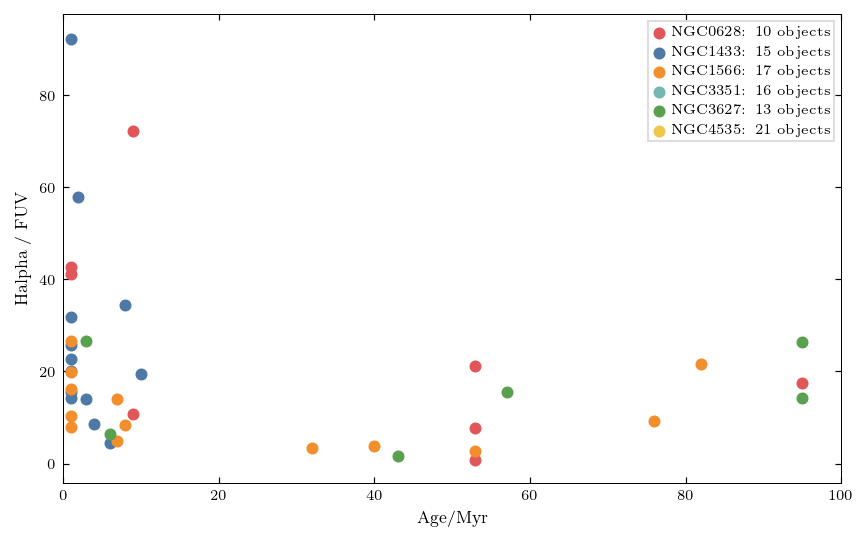

In [17]:
fig,ax=plt.subplots(figsize=(two_column,two_column/1.618))

for name in np.unique(catalogue['gal_name']):
    criteria = (catalogue['AGE_MINCHISQ']<20) & (catalogue['MASS_MINCHISQ']>1e3)
    tmp = catalogue[(catalogue['gal_name']==name)]
    ax.scatter(tmp['AGE_MINCHISQ'],tmp['HA/FUV'],label=f'{name}: {len(tmp)} objects')

ax.legend()
ax.set(xlabel='Age/Myr',ylabel='Halpha / FUV',xlim=[0,100])

plt.savefig(basedir/'reports'/'HaFUV_over_age.png',dpi=600)
plt.show()

## Plot regions (MUSE & HST over WFI)

IC5332
NGC0628
NGC1087
NGC1300
NGC1365
NGC1385
NGC1433
NGC1512
NGC1566
NGC1672
NGC2835
NGC3351
NGC3627
NGC4254
NGC4303
NGC4321
NGC4535
NGC5068
NGC7496


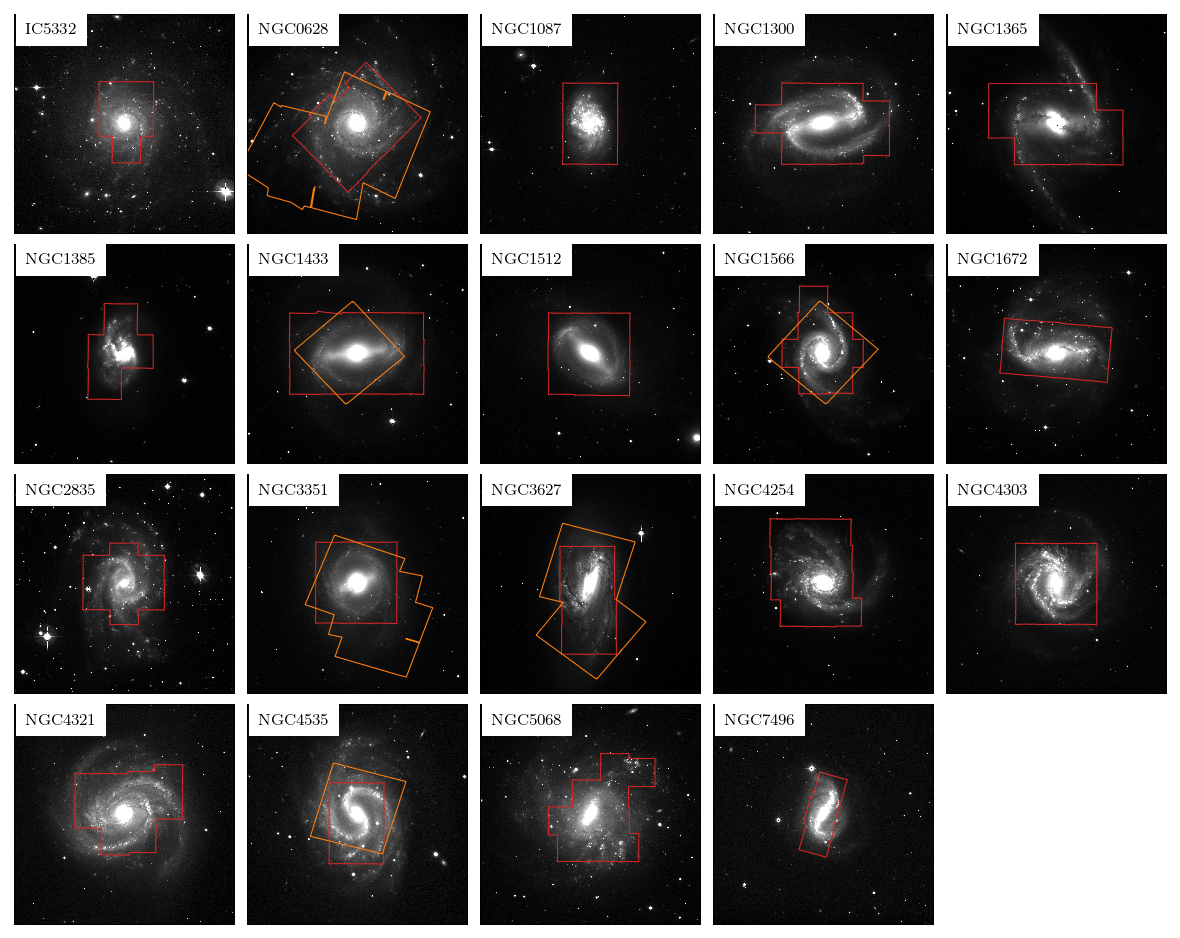

In [8]:
from astropy.nddata import Cutout2D
from cluster.regions import find_sky_region

sample = set([x.stem.split('_')[0].upper() for x in (data_ext/'HST'/'white_light').iterdir()])
sample = muse_sample
ncols = 5
nrows = int(np.ceil(len(sample)/ncols))

width = 1.5*two_column
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes_iter = iter(axes.flatten())

for name in sorted(sample):
    
    print(name)
    
    if name in hst_sample:
        with fits.open(data_ext / 'HST' / 'white_light' / f'{name.lower()}_white_24rgb.fits') as hdul:
            hst_whitelight = NDData(hdul[0].data,mask=hdul[0].data==0,meta=hdul[0].header,wcs=WCS(hdul[0].header))
            hst_whitelight.data[hst_whitelight.data==0] = np.nan
        
    filename = data_ext / 'MUSE_DR2' / 'MUSEDAP' / f'{name}_MAPS.fits'
    with fits.open(filename) as hdul:
        Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                        uncertainty=StdDevUncertainty(hdul['HA6562_FLUX_ERR'].data),
                        mask=np.isnan(hdul['HA6562_FLUX'].data),
                        meta=hdul['HA6562_FLUX'].header,
                        wcs=WCS(hdul['HA6562_FLUX'].header))
        
    filename = data_ext / 'WFI' / f'{name}_Rc_flux_nosky.fits'
    with fits.open(filename) as hdul:

        WFI = NDData(data=hdul[0].data,
                     meta=hdul[0].header,
                     wcs=WCS(hdul[0].header))
        

    reg_muse_pix, reg_muse_sky = find_sky_region(Halpha.mask.astype(int),wcs=Halpha.wcs)
    if name in hst_sample:
        reg_hst_pix, reg_hst_sky = find_sky_region(hst_whitelight.mask.astype(int),wcs=hst_whitelight.wcs)
    
    WFI_cutout = Cutout2D(WFI.data,sample_table.loc[name]['SkyCoord'],size=8*u.arcmin,wcs=WFI.wcs)
    
    # project from muse to hst coordinates
    reg_muse_wfi = reg_muse_sky.to_pixel(WFI_cutout.wcs)
    if name in hst_sample:
        reg_hst_wfi  = reg_hst_sky.to_pixel(WFI_cutout.wcs)

    ax = next(axes_iter)

    # plot image
    norm = simple_norm(WFI_cutout.data,clip=False,percent=99)
    ax.imshow(WFI_cutout.data,norm=norm,cmap=plt.cm.gray,origin='lower')

    reg_muse_wfi.plot(ax=ax,ec='tab:red',label='MUSE',lw=0.5)
    if name in hst_sample:
        reg_hst_wfi.plot(ax=ax,ec='tab:orange',label='HST',lw=0.5)
    t = ax.text(0.05,0.91,name, transform=ax.transAxes,color='black',fontsize=8)
    t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))

    ax.set_xticks([])
    ax.set_yticks([])

for i in range(nrows*ncols-len(sample)):

    # remove the empty axes at the bottom
    ax = next(axes_iter)
    ax.remove()

plt.subplots_adjust(wspace=-0.01,hspace=0.05)
plt.savefig(basedir/'reports'/'all_objects.pdf',dpi=600)
plt.savefig(basedir/'reports'/'all_objects.png',dpi=600)

plt.show()

In [ ]:
from astropy.nddata import Cutout2D
from cluster.regions import find_sky_region


ncols = 5
nrows = int(np.ceil(len(muse_sample)/ncols))

width = 1.5*two_column
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes_iter = iter(axes.flatten())

for name in sorted(muse_sample):
    
    print(name)
    
    catalogue_file = basedir/'..'/'PNLF'/'data'/'catalogues'/f'{name}_nebulae.txt'
    catalogue = ascii.read(catalogue_file,format='fixed_width_two_line',delimiter_pad=' ',position_char='=')
    catalogue['SkyCoord'] = SkyCoord(catalogue['RaDec'])
    catalogue=catalogue[catalogue['type']=='PN']
    
    filename = data_ext / 'WFI' / f'{name}_Rc_flux_nosky.fits'
    with fits.open(filename) as hdul:

        WFI = NDData(data=hdul[0].data,
                     meta=hdul[0].header,
                     wcs=WCS(hdul[0].header))
        
    
    WFI_cutout = Cutout2D(WFI.data,sample_table.loc[name]['SkyCoord'],size=5*u.arcmin,wcs=WFI.wcs)

    ax = next(axes_iter)

    # plot image
    norm = simple_norm(WFI_cutout.data,clip=False,percent=99)
    ax.imshow(WFI_cutout.data,norm=norm,cmap=plt.cm.gray,origin='lower')
    
    x,y = catalogue['SkyCoord'].to_pixel(WFI_cutout.wcs)
    ax.scatter(x,y,marker='o',ec='tab:red',fc='none',s=1,lw=0.2)
    
    t = ax.text(0.05,0.91,name, transform=ax.transAxes,color='black',fontsize=8)
    t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))

    ax.set_xticks([])
    ax.set_yticks([])

for i in range(nrows*ncols-len(muse_sample)):

    # remove the empty axes at the bottom
    ax = next(axes_iter)
    ax.remove()

plt.subplots_adjust(wspace=-0.01,hspace=0.05)
plt.savefig(basedir/'reports'/'all_objects_PN.pdf',dpi=600)
plt.show()

In [ ]:
from astropy.nddata import Cutout2D
from cluster.regions import find_sky_region


ncols = 5
nrows = int(np.ceil(len(muse_sample)/ncols))

width = 1.5*two_column
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes_iter = iter(axes.flatten())

for name in sorted(muse_sample):
    
    print(name)
    
    catalogue = filter_table(nebulae,gal_name=name)
    #catalogue['SkyCoord'] = SkyCoord(catalogue['RaDec'])
    
    filename = data_ext / 'WFI' / f'{name}_Rc_flux_nosky.fits'
    with fits.open(filename) as hdul:
        WFI = NDData(data=hdul[0].data,
                     meta=hdul[0].header,
                     wcs=WCS(hdul[0].header))
        
    
    WFI_cutout = Cutout2D(WFI.data,sample_table.loc[name]['SkyCoord'],size=5*u.arcmin,wcs=WFI.wcs)

    ax = next(axes_iter)

    # plot image
    norm = simple_norm(WFI_cutout.data,clip=False,percent=99)
    ax.imshow(WFI_cutout.data,norm=norm,cmap=plt.cm.gray,origin='lower')
    
    x,y = catalogue['SkyCoord'].to_pixel(WFI_cutout.wcs)
    ax.scatter(x,y,marker='o',ec='tab:blue',fc='none',s=1,lw=0.2)
    
    t = ax.text(0.05,0.91,name, transform=ax.transAxes,color='black',fontsize=8)
    t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))

    ax.set_xticks([])
    ax.set_yticks([])

for i in range(nrows*ncols-len(muse_sample)):

    # remove the empty axes at the bottom
    ax = next(axes_iter)
    ax.remove()

plt.subplots_adjust(wspace=-0.01,hspace=0.05)
plt.savefig(basedir/'reports'/'all_objects_nebulae.pdf',dpi=600)
plt.show()

## Playground